# EDA - AIRLINE DELAY PREDICTION PROJECT

In [1]:
# Importaciones básicas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn

# Importaciones para procesamiento de datos y funcionales
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json
from pickle import dump
import gc

# Importaciones para modelado
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score


# 1. Recolección de Datos

In [2]:
df = pd.read_parquet("../data/raw/Combined_Flights_2022.parquet", engine="pyarrow")

In [3]:
#Información básica del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4078318 entries, 0 to 590541
Data columns (total 61 columns):
 #   Column                                   Dtype         
---  ------                                   -----         
 0   FlightDate                               datetime64[us]
 1   Airline                                  object        
 2   Origin                                   object        
 3   Dest                                     object        
 4   Cancelled                                bool          
 5   Diverted                                 bool          
 6   CRSDepTime                               int64         
 7   DepTime                                  float64       
 8   DepDelayMinutes                          float64       
 9   DepDelay                                 float64       
 10  ArrTime                                  float64       
 11  ArrDelayMinutes                          float64       
 12  AirTime                           

In [4]:
#Primeras filas para visualizar los datos
df.head()

FlightDate                                    Airline Origin Dest  \
0 2022-04-04  Commutair Aka Champlain Enterprises, Inc.    GJT  DEN   
1 2022-04-04  Commutair Aka Champlain Enterprises, Inc.    HRL  IAH   
2 2022-04-04  Commutair Aka Champlain Enterprises, Inc.    DRO  DEN   
3 2022-04-04  Commutair Aka Champlain Enterprises, Inc.    IAH  GPT   
4 2022-04-04  Commutair Aka Champlain Enterprises, Inc.    DRO  DEN   

   Cancelled  Diverted  CRSDepTime  DepTime  DepDelayMinutes  DepDelay  ...  \
0      False     False        1133   1123.0              0.0     -10.0  ...   
1      False     False         732    728.0              0.0      -4.0  ...   
2      False     False        1529   1514.0              0.0     -15.0  ...   
3      False     False        1435   1430.0              0.0      -5.0  ...   
4      False     False        1135   1135.0              0.0       0.0  ...   

   WheelsOff  WheelsOn  TaxiIn  CRSArrTime  ArrDelay  ArrDel15  \
0     1140.0    1220.0     8.0        1245     -17.0       0.0   
1      744.0     839.0     9.0         849      -1.0       0.0   
2     1535.0    1622.0    14.0        1639      -3.0       0.0   
3     1446.0    1543.0     4.0        1605     -18.0       0.0   
4     1154.0    1243.0     8.0        1245       6.0       0.0   

   ArrivalDelayGroups  ArrTimeBlk  DistanceGroup  DivAirportLandings  
0                -2.0   1200-1259              1                   0  
1                -1.0   0800-0859              2                   0  
2                -1.0   1600-1659              2                   0  
3                -2.0   1600-1659              2                   0  
4                 0.0   1200-1259              2                   0  

[5 rows x 61 columns]

In [5]:
#Verificar valores nulos
df.isnull().sum()

FlightDate                 0
Airline                    0
Origin                     0
Dest                       0
Cancelled                  0
                       ...  
ArrDel15              133402
ArrivalDelayGroups    133402
ArrTimeBlk                 0
DistanceGroup              0
DivAirportLandings         0
Length: 61, dtype: int64

In [6]:
#Estadísticos descriptivos
df.describe()

FlightDate    CRSDepTime       DepTime  \
count                     4078318  4.078318e+06  3.957885e+06   
mean   2022-04-18 12:10:43.903101  1.329587e+03  1.334374e+03   
min           2022-01-01 00:00:00  1.000000e+00  1.000000e+00   
25%           2022-02-25 00:00:00  9.140000e+02  9.170000e+02   
50%           2022-04-19 00:00:00  1.320000e+03  1.325000e+03   
75%           2022-06-11 00:00:00  1.735000e+03  1.744000e+03   
max           2022-07-31 00:00:00  2.359000e+03  2.400000e+03   
std                           NaN  4.904801e+02  5.056219e+02   

       DepDelayMinutes      DepDelay       ArrTime  ArrDelayMinutes  \
count     3.957823e+06  3.957823e+06  3.954079e+06     3.944916e+06   
mean      1.601494e+01  1.309049e+01  1.457886e+03     1.578307e+01   
min       0.000000e+00 -7.800000e+01  1.000000e+00     0.000000e+00   
25%       0.000000e+00 -5.000000e+00  1.046000e+03     0.000000e+00   
50%       0.000000e+00 -2.000000e+00  1.500000e+03     0.000000e+00   
75%       1.100000e+01  1.100000e+01  1.914000e+03     1.000000e+01   
max       7.223000e+03  7.223000e+03  2.400000e+03     7.232000e+03   
std       5.231498e+01  5.332016e+01  5.431841e+02     5.198424e+01   

            AirTime  CRSElapsedTime  ActualElapsedTime  ...       TaxiOut  \
count  3.944916e+06    4.078318e+06       3.944916e+06  ...  3.955652e+06   
mean   1.110075e+02    1.413211e+02       1.358624e+02  ...  1.697375e+01   
min    8.000000e+00   -4.800000e+01       1.400000e+01  ...  1.000000e+00   
25%    6.000000e+01    8.900000e+01       8.300000e+01  ...  1.100000e+01   
50%    9.400000e+01    1.240000e+02       1.190000e+02  ...  1.500000e+01   
75%    1.410000e+02    1.710000e+02       1.670000e+02  ...  1.900000e+01   
max    7.270000e+02    6.900000e+02       7.640000e+02  ...  2.210000e+02   
std    6.996246e+01    7.179635e+01       7.185501e+01  ...  9.495407e+00   

          WheelsOff      WheelsOn        TaxiIn    CRSArrTime      ArrDelay  \
count  3.955652e+06  3.954076e+06  3.954076e+06  4.078318e+06  3.944916e+06   
mean   1.356576e+03  1.455073e+03  7.894387e+00  1.486058e+03  7.528486e+00   
min    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00 -1.000000e+02   
25%    9.320000e+02  1.044000e+03  4.000000e+00  1.103000e+03 -1.400000e+01   
50%    1.338000e+03  1.456000e+03  6.000000e+00  1.513000e+03 -5.000000e+00   
75%    1.758000e+03  1.909000e+03  9.000000e+00  1.920000e+03  1.000000e+01   
max    2.400000e+03  2.400000e+03  2.900000e+02  2.359000e+03  7.232000e+03   
std    5.075580e+02  5.378428e+02  6.663118e+00  5.185078e+02  5.524625e+01   

           ArrDel15  ArrivalDelayGroups  DistanceGroup  DivAirportLandings  
count  3.944916e+06        3.944916e+06   4.078318e+06        4.078318e+06  
mean   2.164715e-01       -6.256103e-02   3.663516e+00        3.685098e-03  
min    0.000000e+00       -2.000000e+00   1.000000e+00        0.000000e+00  
25%    0.000000e+00       -1.000000e+00   2.000000e+00        0.000000e+00  
50%    0.000000e+00       -1.000000e+00   3.000000e+00        0.000000e+00  
75%    0.000000e+00        0.000000e+00   5.000000e+00        0.000000e+00  
max    1.000000e+00        1.200000e+01   1.100000e+01        9.000000e+00  
std    4.118393e-01        2.487442e+00   2.320848e+00        1.141331e-01  

[8 rows x 42 columns]

# 2. Exploración y limpieza de datos

## Explicación de Columnas - Dataset de Vuelos

### Información del Vuelo
* **FlightDate**: Fecha del vuelo (año, mes y día)
* **Airline**: Código de aerolínea operadora
* **Origin**: Código IATA aeropuerto origen
* **Dest**: Código IATA aeropuerto destino

### Indicadores de Interrupción
* **Cancelled**: Vuelo cancelado (1=Sí, 0=No)
* **Diverted**: Vuelo desviado (1=Sí, 0=No)

### Horarios y Retrasos
#### Salida
* **CRSDepTime**: Hora programada salida
* **DepTime**: Hora real salida
* **DepDelayMinutes**: Minutos de retraso salida
* **DepDelay**: Retraso salida (negativo=anticipado)

#### Llegada
* **ArrTime**: Hora real llegada
* **ArrDelayMinutes**: Minutos retraso llegada 
* **ArrDelay**: Retraso llegada (negativo=anticipada)

### Duración
* **AirTime**: Minutos en aire
* **CRSElapsedTime**: Tiempo estimado total
* **ActualElapsedTime**: Tiempo real total

### Geografía y Tiempo
* **Distance**: Distancia en millas
* **Year**: Año del vuelo
* **Quarter**: Trimestre (1-4)
* **Month**: Mes (1-12)
* **DayofMonth**: Día del mes
* **DayOfWeek**: Día semana (1=Lunes, 7=Domingo)

### Información Aerolíneas
* **Marketing_Airline_Network**: Aerolínea vendedora
* **Operating_Airline**: Aerolínea operadora física
* **DOT_ID_Marketing_Airline**: ID DOT aerolínea marketing
* **IATA_Code_Marketing_Airline**: Código IATA aerolínea marketing
* **Flight_Number_Marketing_Airline**: Número vuelo marketing
* **DOT_ID_Operating_Airline**: ID DOT aerolínea operadora
* **IATA_Code_Operating_Airline**: Código IATA aerolínea operadora

### Aeronave
* **Tail_Number**: Matrícula única
* **Flight_Number_Operating_Airline**: Número vuelo operativo

### Aeropuerto Origen
* **OriginAirportID**: ID único
* **OriginAirportSeqID**: ID secuencia
* **OriginCityMarketID**: ID mercado ciudad
* **OriginCityName**: Nombre ciudad
* **OriginState**: Abreviación estado
* **OriginStateFips**: Código FIPS estado
* **OriginStateName**: Nombre estado
* **OriginWac**: Código WAC

### Aeropuerto Destino
* **DestAirportID**: ID único
* **DestAirportSeqID**: ID secuencia
* **DestCityMarketID**: ID mercado ciudad
* **DestCityName**: Nombre ciudad
* **DestState**: Abreviación estado
* **DestStateFips**: Código FIPS estado
* **DestStateName**: Nombre estado
* **DestWac**: Código WAC

### Indicadores Retraso Salida
* **DepDel15**: Retraso >15 min (1=Sí, 0=No)
* **DepartureDelayGroups**: Grupos de retraso
* **DepTimeBlk**: Bloque horario (ej: "0700-0759")

### Movimientos Aeronave
* **TaxiOut**: Minutos en pista antes despegue
* **WheelsOff**: Hora despegue
* **WheelsOn**: Hora aterrizaje
* **TaxiIn**: Minutos en pista post-aterrizaje

### Indicadores Retraso Llegada
* **CRSArrTime**: Hora programada llegada
* **ArrDel15**: Retraso >15 min (1=Sí, 0=No)
* **ArrivalDelayGroups**: Grupos de retraso
* **ArrTimeBlk**: Bloque horario llegada

### Otros Indicadores
* **DistanceGroup**: Grupos por distancia
* **DivAirportLandings**: Aterrizajes no programados

In [7]:
#Dimensiones del dataset
print("Dimensiones del dataset:", df.shape)

Dimensiones del dataset: (4078318, 61)


In [8]:
#Tipos de datos
print("Tipos de datos:")
print(df.dtypes)

Tipos de datos:
FlightDate            datetime64[us]
Airline                       object
Origin                        object
Dest                          object
Cancelled                       bool
                           ...      
ArrDel15                     float64
ArrivalDelayGroups           float64
ArrTimeBlk                    object
DistanceGroup                  int64
DivAirportLandings             int64
Length: 61, dtype: object


In [9]:
#Identificación de columnas
print(df.columns)

Index(['FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted',
       'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime',
       'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime',
       'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline',
       'Flight_Number_Marketing_Airline', 'Operating_Airline',
       'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
       'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName',
       'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName',
       'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepDel15',
       'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOu

## 2.1 Clasificación de los features

### a. Información redundante o irrelevante para el objetivo
Estas columnas no aportan valor predictivo o contienen información que no estará disponible antes del despegue.

| **Columna(s)**                                                                                                         | **Descripción**                                                                                              |
|------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------|
| **'DepTime', 'DepDelayMinutes', 'DepDelay'**                                                                             | Dependen del retraso real al momento de la salida, que es lo que queremos predecir.                         |
| **'ArrTime', 'ArrDelayMinutes', 'AirTime', 'ActualElapsedTime', 'ArrDelay', 'ArrDel15', 'ArrivalDelayGroups'**           | Información posterior al despegue.                                                                          |
| **'Cancelled', 'Diverted', 'DivAirportLandings'**                                                                        | Indican si el vuelo fue cancelado o desviado, lo cual no es útil para predecir retrasos antes del despegue.  |
| **'WheelsOff', 'WheelsOn', 'TaxiOut', 'TaxiIn'**                                                                         | Información posterior al despegue.                                                                          |
| **'Tail_Number'**                                                                                                        | No aporta información relevante y puede introducir ruido.                                                   |
| **'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID'**| IDs redundantes que pueden ser reemplazados con información más significativa como el nombre del aeropuerto o la ciudad. |
| **'OriginWac', 'DestWac'**                                                                                               | Códigos geográficos redundantes.                                                                            |



### b. Información que podría ser útil pero requiere validación
Estas columnas pueden tener correlación con retrasos, pero debemos evaluar su utilidad.

| **Columna(s)**                                                                                                         | **Descripción**                                                                                              |
|------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------|
| **'FlightDate'**                                                                                                         | Podría ser relevante si extraemos características como feriados, temporada alta, etc.                       |
| **'Flight_Number_Marketing_Airline', 'Flight_Number_Operating_Airline'**                                                 | Dato granular que podría ser redundante con la aerolínea y menos práctico para usuarios en una página web.   |
| **'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners'**                                               | Podrían correlacionarse con retrasos, pero hay que evitar redundancia con otras columnas relacionadas a la aerolínea. |
| **'DOT_ID_Marketing_Airline', 'DOT_ID_Operating_Airline', 'IATA_Code_Marketing_Airline', 'IATA_Code_Operating_Airline'** | IDs redundantes con el nombre de la aerolínea.                                                              |
| **'DistanceGroup'**                                                                                                      | Es categórica, pero podría ser redundante con **'Distance'**.                                                 |
| **'DepartureDelayGroups'**                                                                                               | Representa rangos de retrasos, pero depende del retraso real, por lo que no será útil.                      |



### c. Información clave para el modelo
Estas columnas probablemente tendrán mayor impacto en la predicción.

| **Columna(s)**                                                                 | **Descripción**                                                                                         |
|--------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **'Airline', 'Operating_Airline'**                                               | Las aerolíneas pueden tener diferentes tasas de puntualidad.                                           |
| **'Origin', 'Dest', 'OriginCityName', 'DestCityName', 'OriginState', 'DestState'**| Lugares de origen y destino son cruciales, ya que algunos aeropuertos tienen mayores tasas de retraso. |
| **'CRSDepTime', 'CRSArrTime', 'DepTimeBlk', 'ArrTimeBlk'**                       | Hora programada y bloque horario pueden correlacionarse con la congestión del aeropuerto y los retrasos.|
| **'Distance'**                                                                   | La distancia entre el origen y el destino puede afectar la probabilidad de retrasos.                   |
| **'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek'**                        | Información temporal que puede capturar tendencias estacionales o semanales.                           |



## Propuesta de columnas finales
Variables seleccionadas para el modelo.

| **Columna(s)**             | **Descripción**                               |
|----------------------------|-----------------------------------------------|
| **'Airline' (o 'Operating_Airline')** | Aerolínea del vuelo.                         |
| **'Origin'**                 | Aeropuerto de origen.                        |
| **'Dest'**                   | Aeropuerto de destino.                       |
| **'OriginCityName'**         | Ciudad de origen.                            |
| **'DestCityName'**           | Ciudad de destino.                           |
| **'OriginState'**            | Estado de origen.                            |
| **'DestState'**              | Estado de destino.                           |
| **'CRSDepTime'**             | Hora programada de salida.                   |
| **'DepTimeBlk'**             | Bloque horario de salida.                    |
| **'Distance'**               | Distancia entre origen y destino.            |
| **'Year'**                   | Año del vuelo.                               |
| **'Quarter'**                | Trimestre del vuelo.                         |
| **'Month'**                  | Mes del vuelo.                               |
| **'DayofMonth'**             | Día del mes del vuelo.                       |
| **'DayOfWeek'**              | Día de la semana del vuelo.                  |


## 2.2 Seleccion de columnas finales eliminación de características irrelevantes y manejo de valores nulos
### Eliminamos filas con valores nulos en características clave

In [10]:
# Definir las columnas finales a utilizar
columnas_finales = [
    'Airline', 'Origin', 'Dest', 'OriginCityName', 'DestCityName',
    'OriginState', 'DestState', 'CRSDepTime', 'DepTimeBlk', 'Distance',
    'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'DepDel15', 'DepDelayMinutes'
]

In [11]:
#Filtrar el DataFrame con las columnas finales
df = df[columnas_finales]

## 2.3 Analisis de nuestro DataFrame

In [12]:
#Primeras filas del dataset final
print("Primeras filas del dataset con columnas finales:")
print(df.head())

Primeras filas del dataset con columnas finales:
                                     Airline Origin Dest  \
0  Commutair Aka Champlain Enterprises, Inc.    GJT  DEN   
1  Commutair Aka Champlain Enterprises, Inc.    HRL  IAH   
2  Commutair Aka Champlain Enterprises, Inc.    DRO  DEN   
3  Commutair Aka Champlain Enterprises, Inc.    IAH  GPT   
4  Commutair Aka Champlain Enterprises, Inc.    DRO  DEN   

             OriginCityName         DestCityName OriginState DestState  \
0        Grand Junction, CO           Denver, CO          CO        CO   
1  Harlingen/San Benito, TX          Houston, TX          TX        TX   
2               Durango, CO           Denver, CO          CO        CO   
3               Houston, TX  Gulfport/Biloxi, MS          TX        MS   
4               Durango, CO           Denver, CO          CO        CO   

   CRSDepTime DepTimeBlk  Distance  Quarter  Month  DayofMonth  DayOfWeek  \
0        1133  1100-1159     212.0        2      4           4      

In [13]:

#Estadísticas descriptivos del dataset final
print("Estadísticas descriptivas del dataset final:")
print(df.describe())

Estadísticas descriptivas del dataset final:
         CRSDepTime      Distance       Quarter         Month    DayofMonth  \
count  4.078318e+06  4.078318e+06  4.078318e+06  4.078318e+06  4.078318e+06   
mean   1.329587e+03  7.978657e+02  1.741207e+00  4.083803e+00  1.571131e+01   
std    4.904801e+02  5.914742e+02  7.037563e-01  1.998918e+00  8.760122e+00   
min    1.000000e+00  3.100000e+01  1.000000e+00  1.000000e+00  1.000000e+00   
25%    9.140000e+02  3.680000e+02  1.000000e+00  2.000000e+00  8.000000e+00   
50%    1.320000e+03  6.430000e+02  2.000000e+00  4.000000e+00  1.600000e+01   
75%    1.735000e+03  1.035000e+03  2.000000e+00  6.000000e+00  2.300000e+01   
max    2.359000e+03  5.095000e+03  3.000000e+00  7.000000e+00  3.100000e+01   

          DayOfWeek      DepDel15  DepDelayMinutes  
count  4.078318e+06  3.957823e+06     3.957823e+06  
mean   4.005566e+00  2.184625e-01     1.601494e+01  
std    2.007050e+00  4.132030e-01     5.231498e+01  
min    1.000000e+00  0.000000e+

In [14]:
#Información del dataset tras la selección de columnas
print("\nInformación del dataset final:")
df.info()


Información del dataset final:
<class 'pandas.core.frame.DataFrame'>
Index: 4078318 entries, 0 to 590541
Data columns (total 16 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Airline          object 
 1   Origin           object 
 2   Dest             object 
 3   OriginCityName   object 
 4   DestCityName     object 
 5   OriginState      object 
 6   DestState        object 
 7   CRSDepTime       int64  
 8   DepTimeBlk       object 
 9   Distance         float64
 10  Quarter          int64  
 11  Month            int64  
 12  DayofMonth       int64  
 13  DayOfWeek        int64  
 14  DepDel15         float64
 15  DepDelayMinutes  float64
dtypes: float64(3), int64(5), object(8)
memory usage: 529.0+ MB


In [15]:
#Conclusión
print("Se han eliminado características redundantes y seleccionado variables clave para la predicción. \n\
El dataset ahora contiene {} filas y {} columnas listas para la modelización.".format(df.shape[0], df.shape[1]))

Se han eliminado características redundantes y seleccionado variables clave para la predicción. 
El dataset ahora contiene 4078318 filas y 16 columnas listas para la modelización.


Además, nuestro data frame contiene los siguientes tipos de datos:

- ****Float****     --> 3
- ****Integer****   --> 6
- ****String****    --> 8

## 2.4 Buscando duplicados, valores vacíos y lidiando con ellos

In [16]:
#Verificar y eliminar duplicados
duplicates = df.duplicated().sum()
print("Número de filas duplicadas antes de limpieza:", duplicates)
df.drop_duplicates(inplace=True)


Número de filas duplicadas antes de limpieza: 768


In [17]:
#Verificar valores nulos en cada columna
missing_values = df.isnull().sum()
print("Valores nulos por columna:")
print(missing_values[missing_values > 0])

Valores nulos por columna:
DepDel15           120483
DepDelayMinutes    120483
dtype: int64


In [18]:
#Eliminar filas con valores nulos
df.dropna(inplace=True)

In [19]:
#Verificar nuevamente valores nulos después del tratamiento
print("Valores nulos después del tratamiento:")
print(df.isnull().sum().sum())

Valores nulos después del tratamiento:
0


In [20]:
#Conclusión rápida
print("Conclusión: Se han eliminado duplicados y valores nulos, asegurando que el dataset esté limpio\ny listo para el análisis posterior. \
Ahora el dataset contiene {} filas y {} columnas.".format(df.shape[0], df.shape[1]))

Conclusión: Se han eliminado duplicados y valores nulos, asegurando que el dataset esté limpio
y listo para el análisis posterior. Ahora el dataset contiene 3957067 filas y 16 columnas.


## 3. Dividiendo el dataset
### 3.1 Dividiendo el dataset en variables categóricas, numéricas y temporales

In [21]:
# Separar variables numéricas y categóricas
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features = [col for col in numerical_features if col not in ['Year']]
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Variables numéricas:", numerical_features)
print("Variables categóricas:", categorical_features)

Variables numéricas: ['CRSDepTime', 'Distance', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'DepDel15', 'DepDelayMinutes']
Variables categóricas: ['Airline', 'Origin', 'Dest', 'OriginCityName', 'DestCityName', 'OriginState', 'DestState', 'DepTimeBlk']


# 4. Análisis Univariado

## 4.1 Análisis de Variables Categóricas

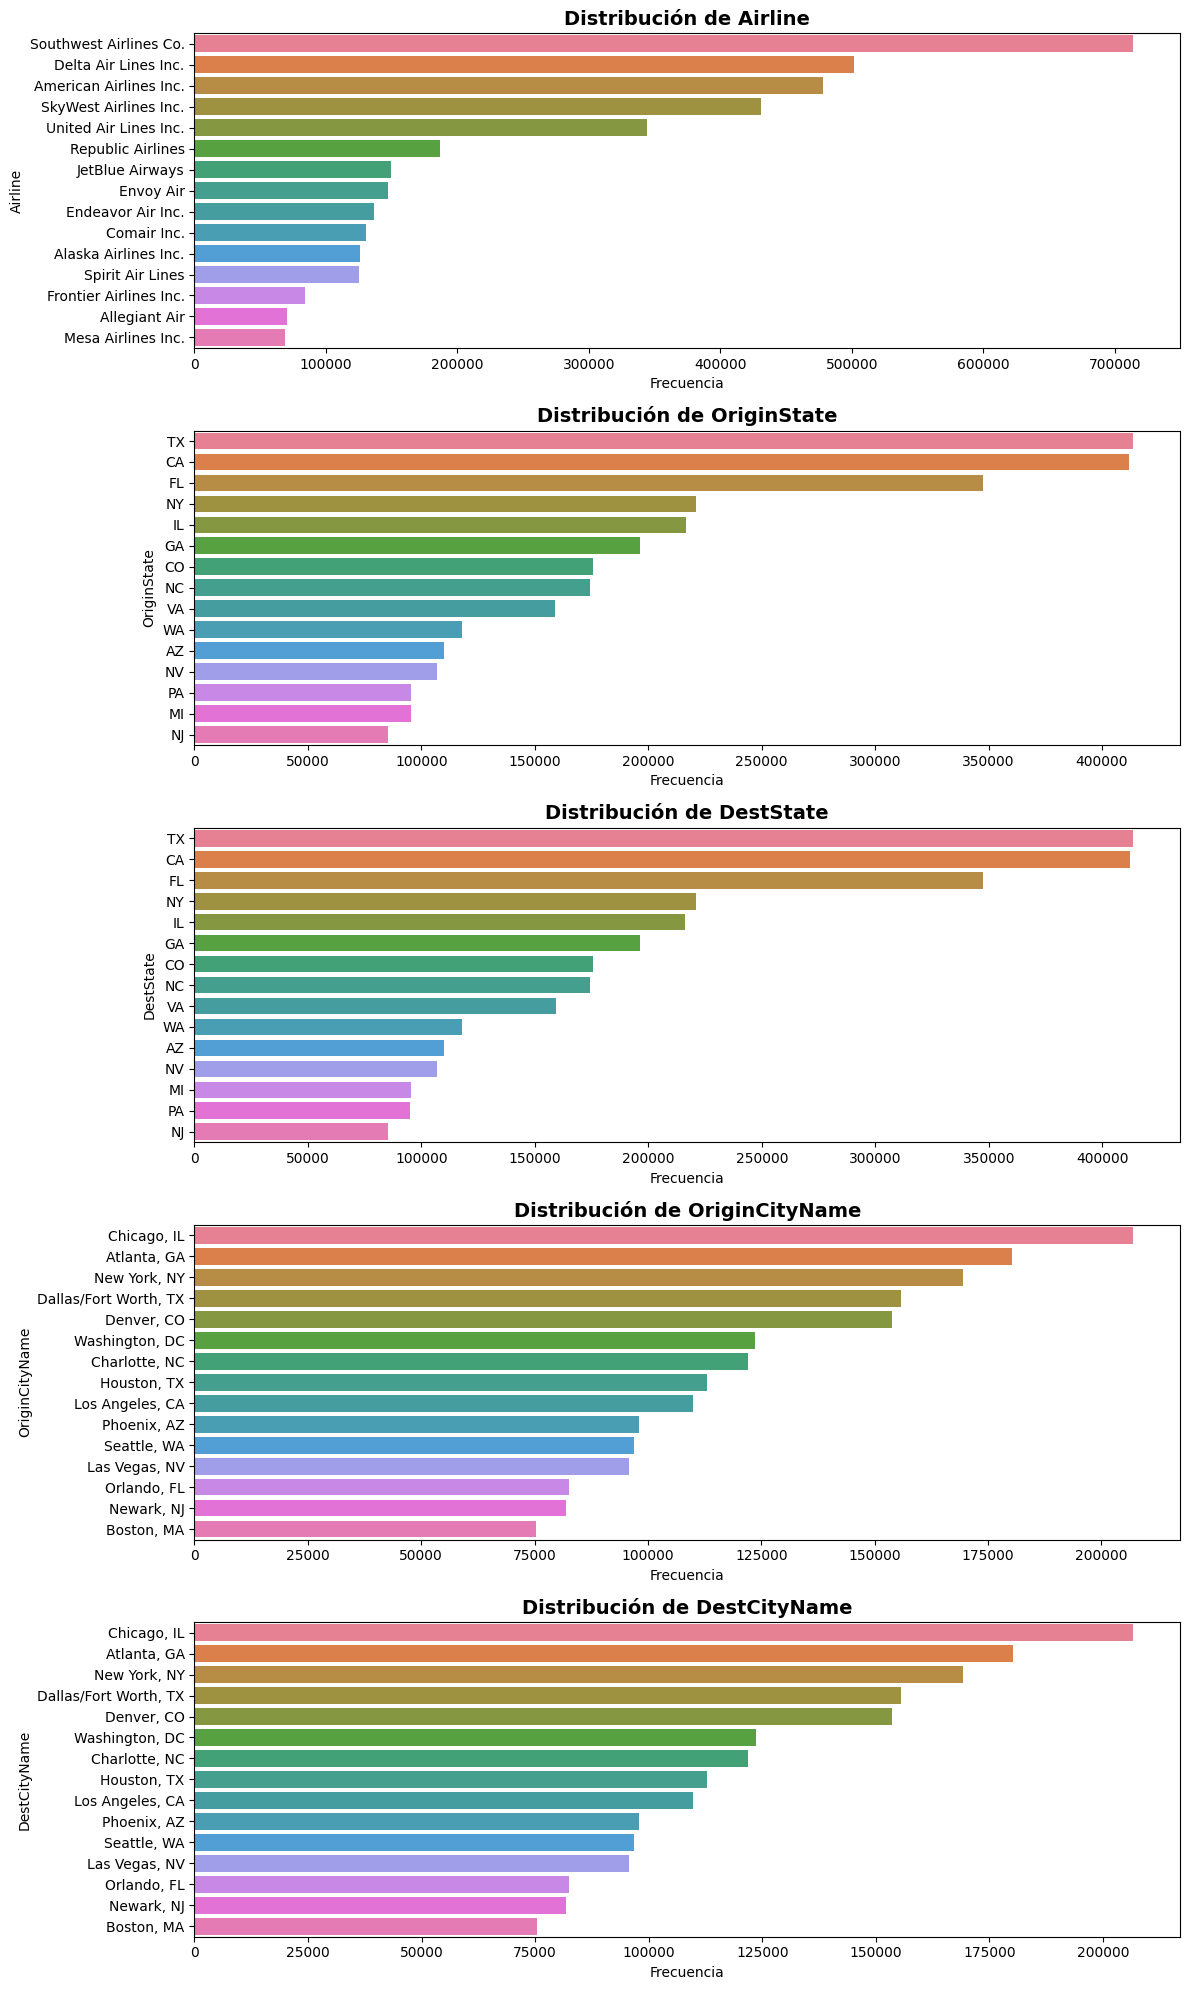

In [22]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12,20))
sns.set_palette("dark")

# Graficar las principales variables categóricas
categorical_vars = ['Airline', 'OriginState', 'DestState', 'OriginCityName', 'DestCityName']
for i, var in enumerate(categorical_vars):
    top_values = df[var].value_counts().head(15)
    sns.barplot(ax=axes[i], y=top_values.index, x=top_values.values, hue=top_values.index, dodge=False)
    axes[i].set_title(f"Distribución de {var}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("Frecuencia")
    axes[i].set_ylabel(var)
    axes[i].tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()

## 4.2 Análisis de Variables Numéricas

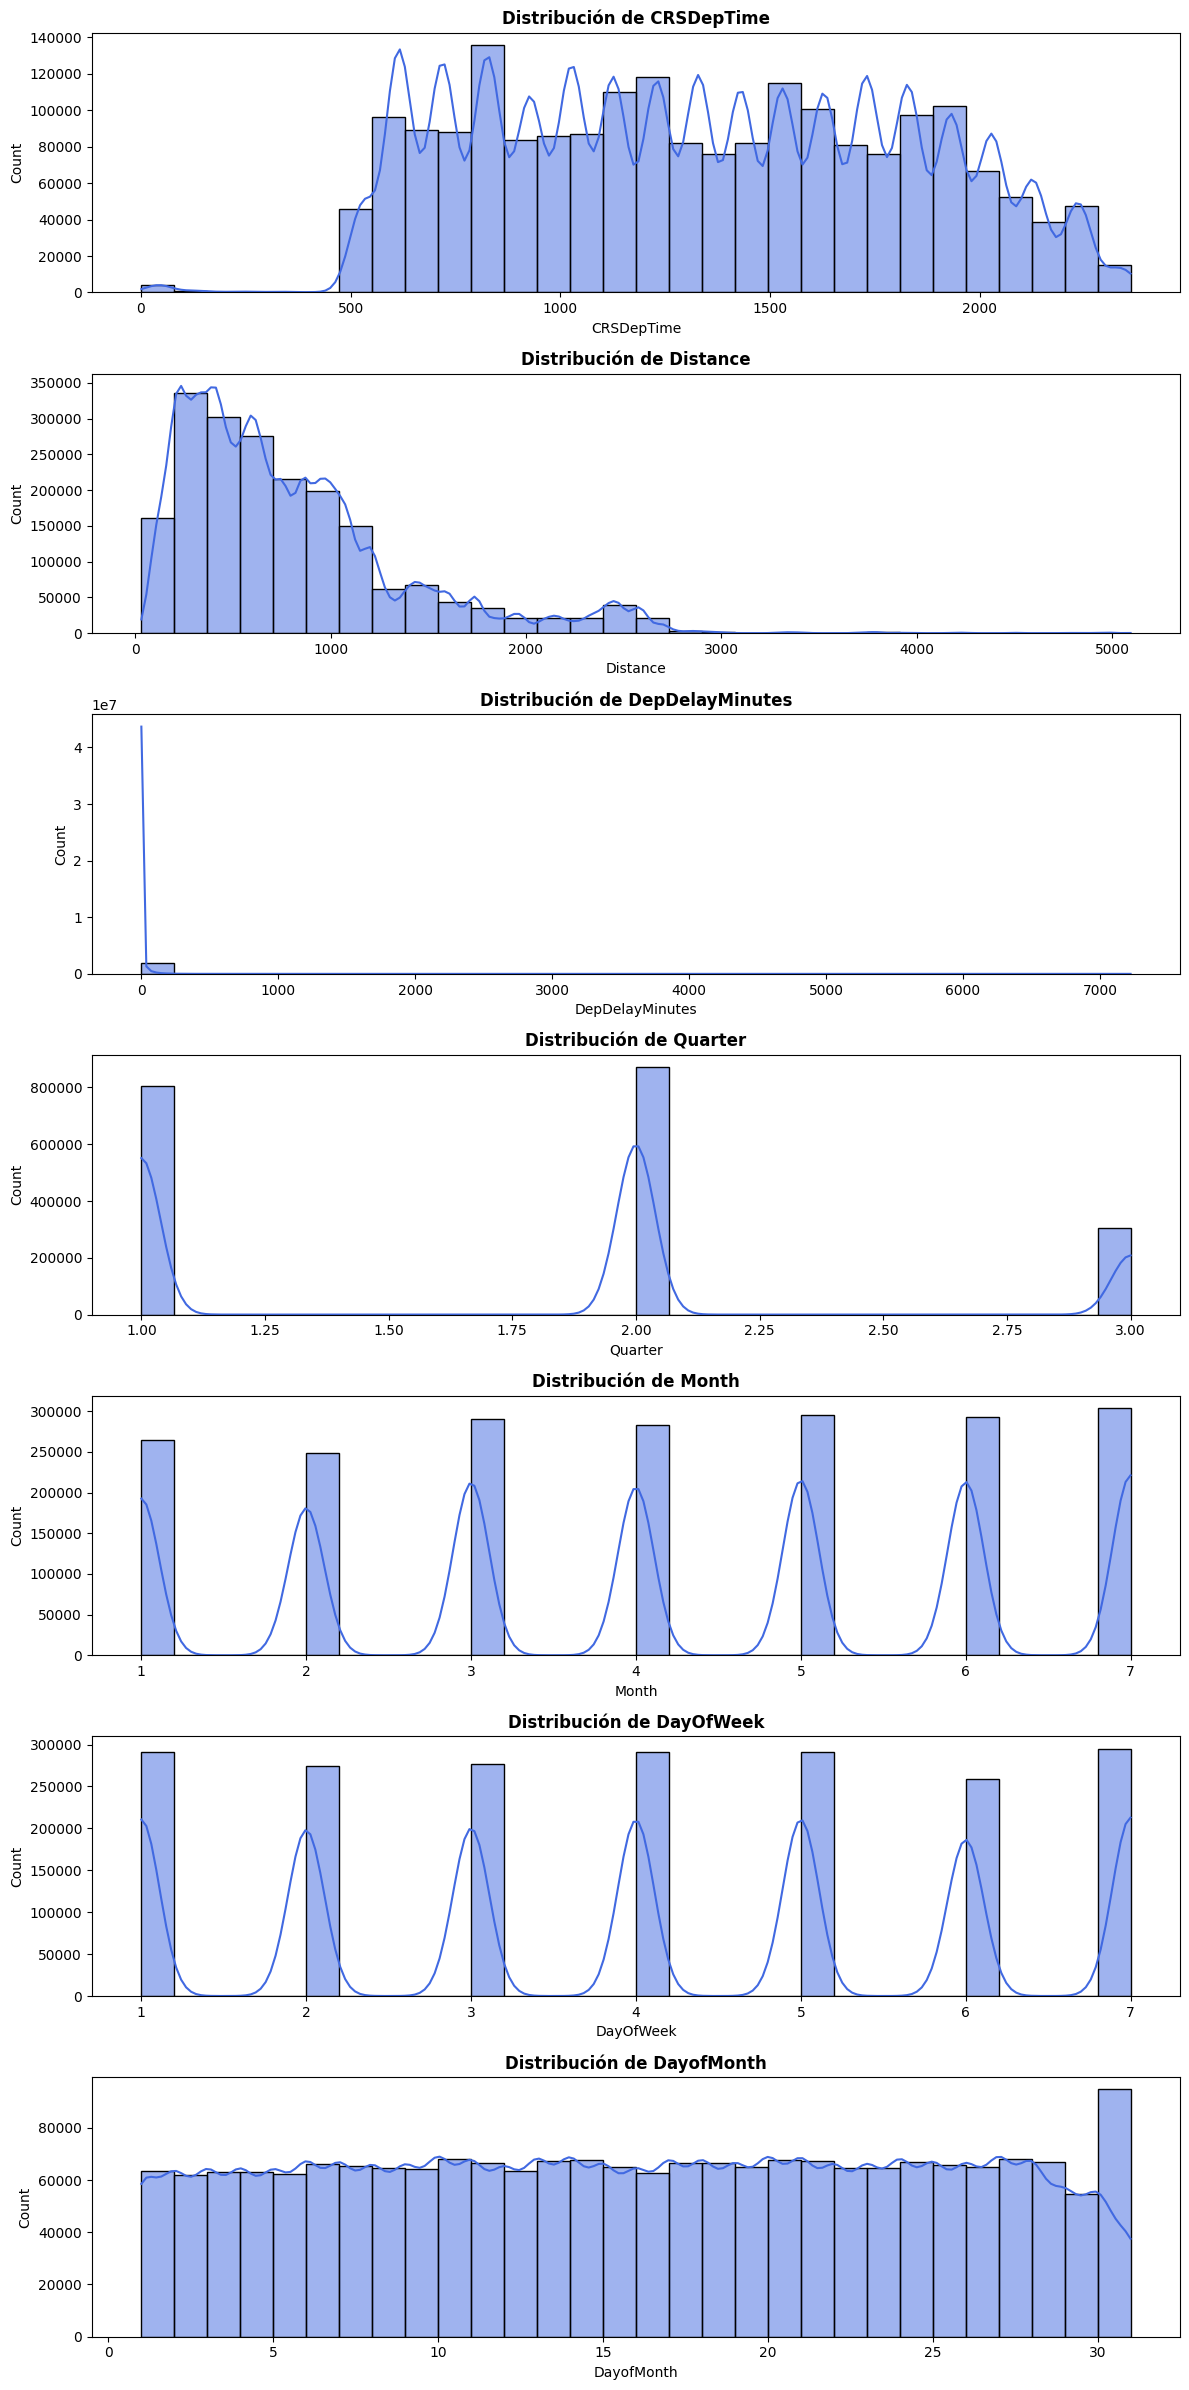

In [24]:
# Configurar visualización
df_sample = df.sample(frac=0.5, random_state=42)
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(12, 24))
num_vars = ['CRSDepTime', 'Distance', 'DepDelayMinutes', 'Quarter', 'Month', 'DayOfWeek', 'DayofMonth']

for i, var in enumerate(num_vars):
    sns.histplot(df_sample[var], ax=axes[i], kde=True, bins=30, color="royalblue")
    axes[i].set_title(f"Distribución de {var}", fontsize=12, fontweight='bold')
    axes[i].set_xlabel(var)

plt.tight_layout()
plt.show()


## 4.3 Análisis Categórico-Categórico

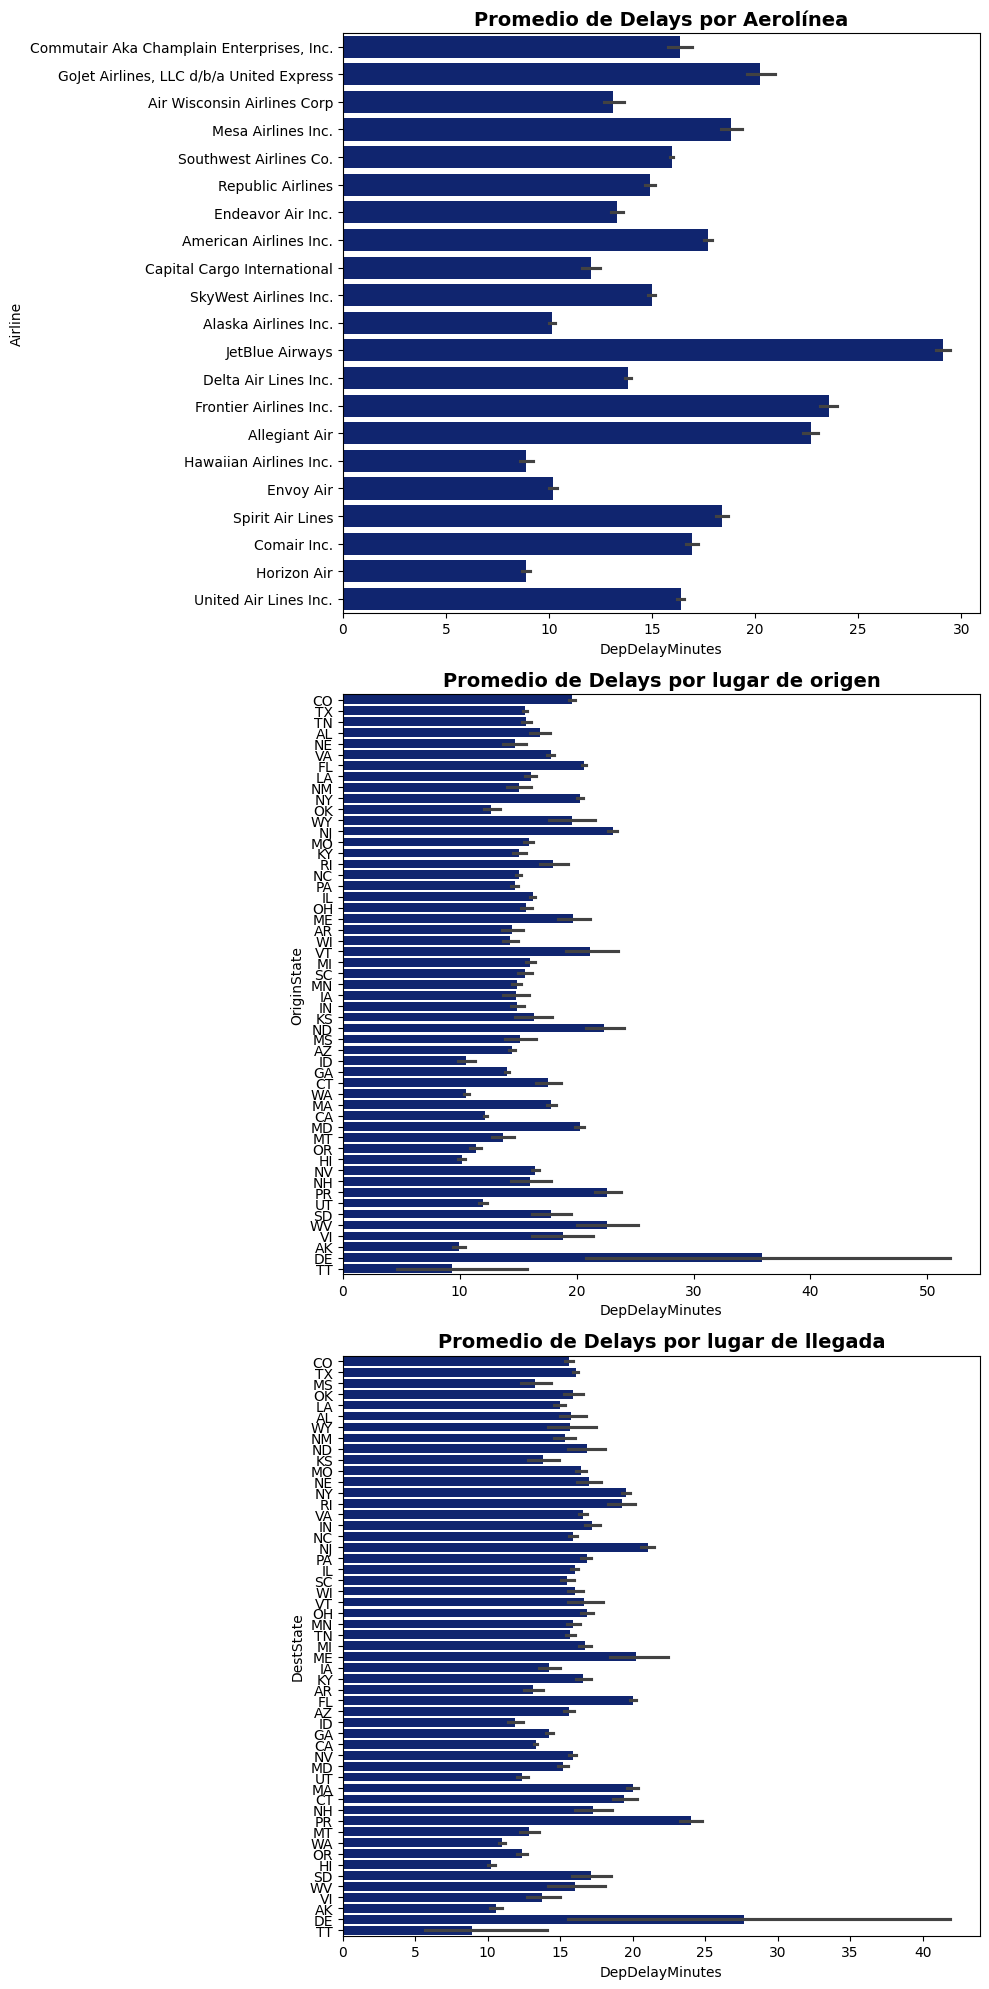

In [ ]:
fig, axis = plt.subplots(3, 1, figsize = (10, 20))

sns.barplot(ax= axis[0], data=df, y='Airline', x='DepDelayMinutes')
sns.barplot(ax= axis[1], data=df, y='OriginState', x='DepDelayMinutes')
sns.barplot(ax= axis[2], data=df, y='DestState', x='DepDelayMinutes')

axis[0].set_title("Promedio de Delays por Aerolínea", fontsize=14, fontweight='bold')
axis[1].set_title("Promedio de Delays por lugar de origen", fontsize=14, fontweight='bold')
axis[2].set_title("Promedio de Delays por lugar de llegada", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4.4 Análisis Numérico-Numérico

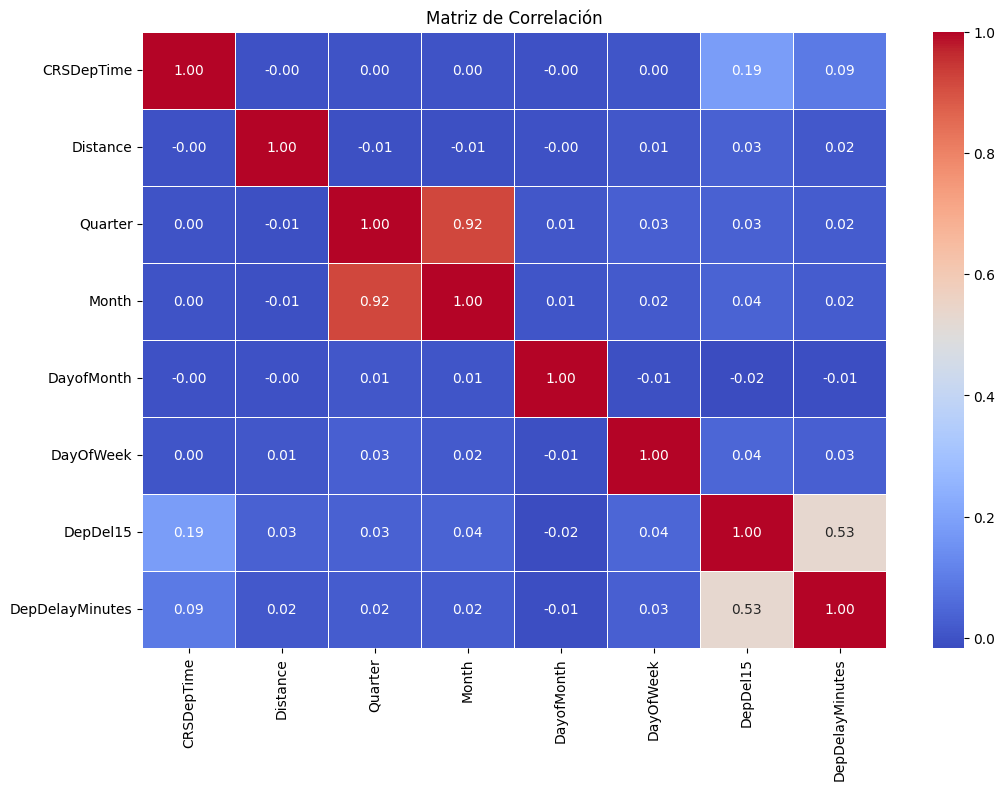

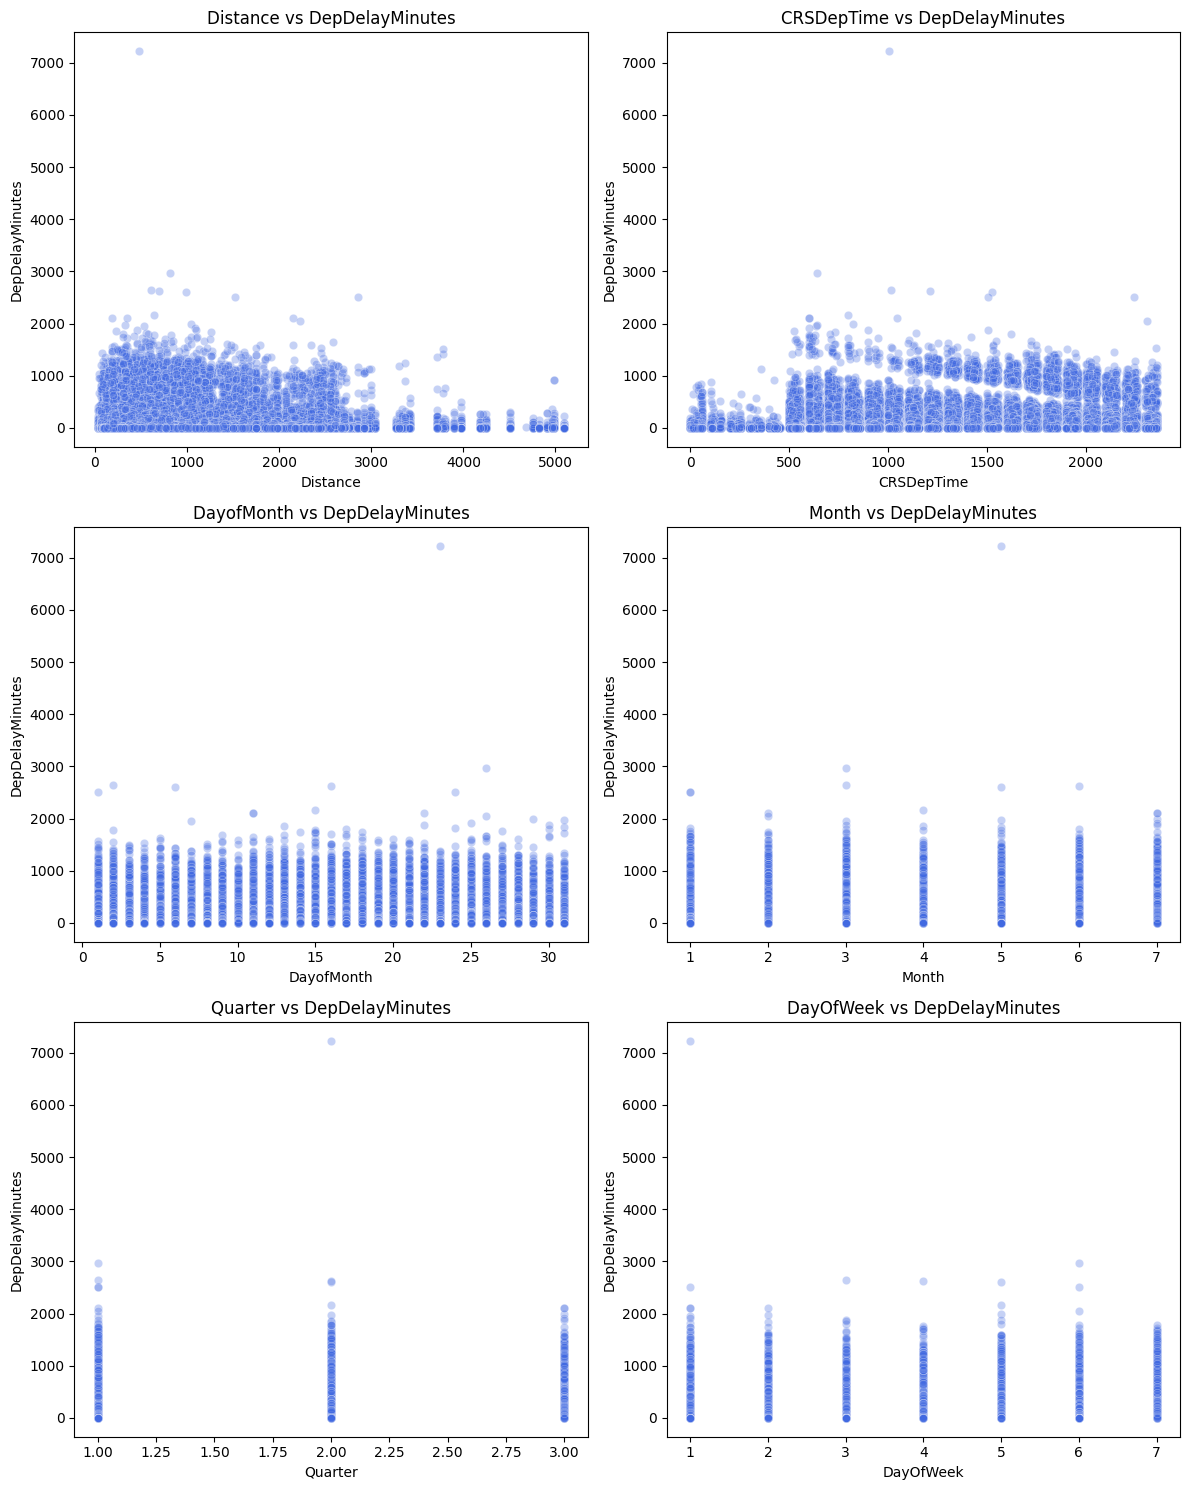

In [ ]:
# Tomar muestra y calcular correlaciones
df_sample = df.sample(frac=0.5, random_state=42)

# Seleccionar solo variables numéricas para la matriz de correlación
df_num = df_sample[numerical_features]
corr_matrix = df_num.corr()

# Visualización de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

vars_to_plot = ['Distance', 'CRSDepTime', 'DayofMonth', 'Month', 'Quarter', 'DayOfWeek']

#Crear la figura con subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

#Generar los gráficos de dispersión
for i, var in enumerate(vars_to_plot):
    row, col = divmod(i, 2)
    sns.scatterplot(ax=axes[row, col], data=df_sample, x=var, y="DepDelayMinutes", alpha=0.3, color="royalblue")
    axes[row, col].set_title(f"{var} vs DepDelayMinutes")

#Ajustar la disposición
plt.tight_layout()
plt.show()

# 5. Multivariate Analysis
## 5.1 Encoding de Variables Categóricas

In [ ]:
#Crear una copia del dataframe para el encoding
df_enc = df.copy()

#Aplicar encoding a variables categóricas y guardar en JSON
for column in categorical_features:
    unique_values = list(df_enc[column].unique())
    encoding_dict = dict(zip(unique_values, range(len(unique_values))))

    #Guardar el encoding en JSON
    with open(f'../data/interim/enc_{column}.json', 'w') as f:
        json.dump(encoding_dict, f)

    #Reemplazar los valores en el DataFrame con su encoding
    df_enc[column] = df_enc[column].map(encoding_dict)

#Confirmar que el encoding se aplicó correctamente
print("Primeras filas del dataset después del encoding:")
print(df_enc.head())


Primeras filas del dataset después del encoding:
   Airline  Origin  Dest  OriginCityName  DestCityName  OriginState  \
0        0       0     0               0             0            0   
1        0       1     1               1             1            1   
2        0       2     0               2             0            0   
3        0       3     2               3             2            1   
4        0       2     0               2             0            0   

   DestState  CRSDepTime  DepTimeBlk  Distance  Quarter  Month  DayofMonth  \
0          0        1133           0     212.0        2      4           4   
1          1         732           1     295.0        2      4           4   
2          0        1529           2     251.0        2      4           4   
3          2        1435           3     376.0        2      4           4   
4          0        1135           0     251.0        2      4           4   

   DayOfWeek  DepDel15  DepDelayMinutes  
0          1 

## 5.2 Numerical - Categorical analysis (Correlational Analysis)

<Figure size 1200x1200 with 0 Axes>

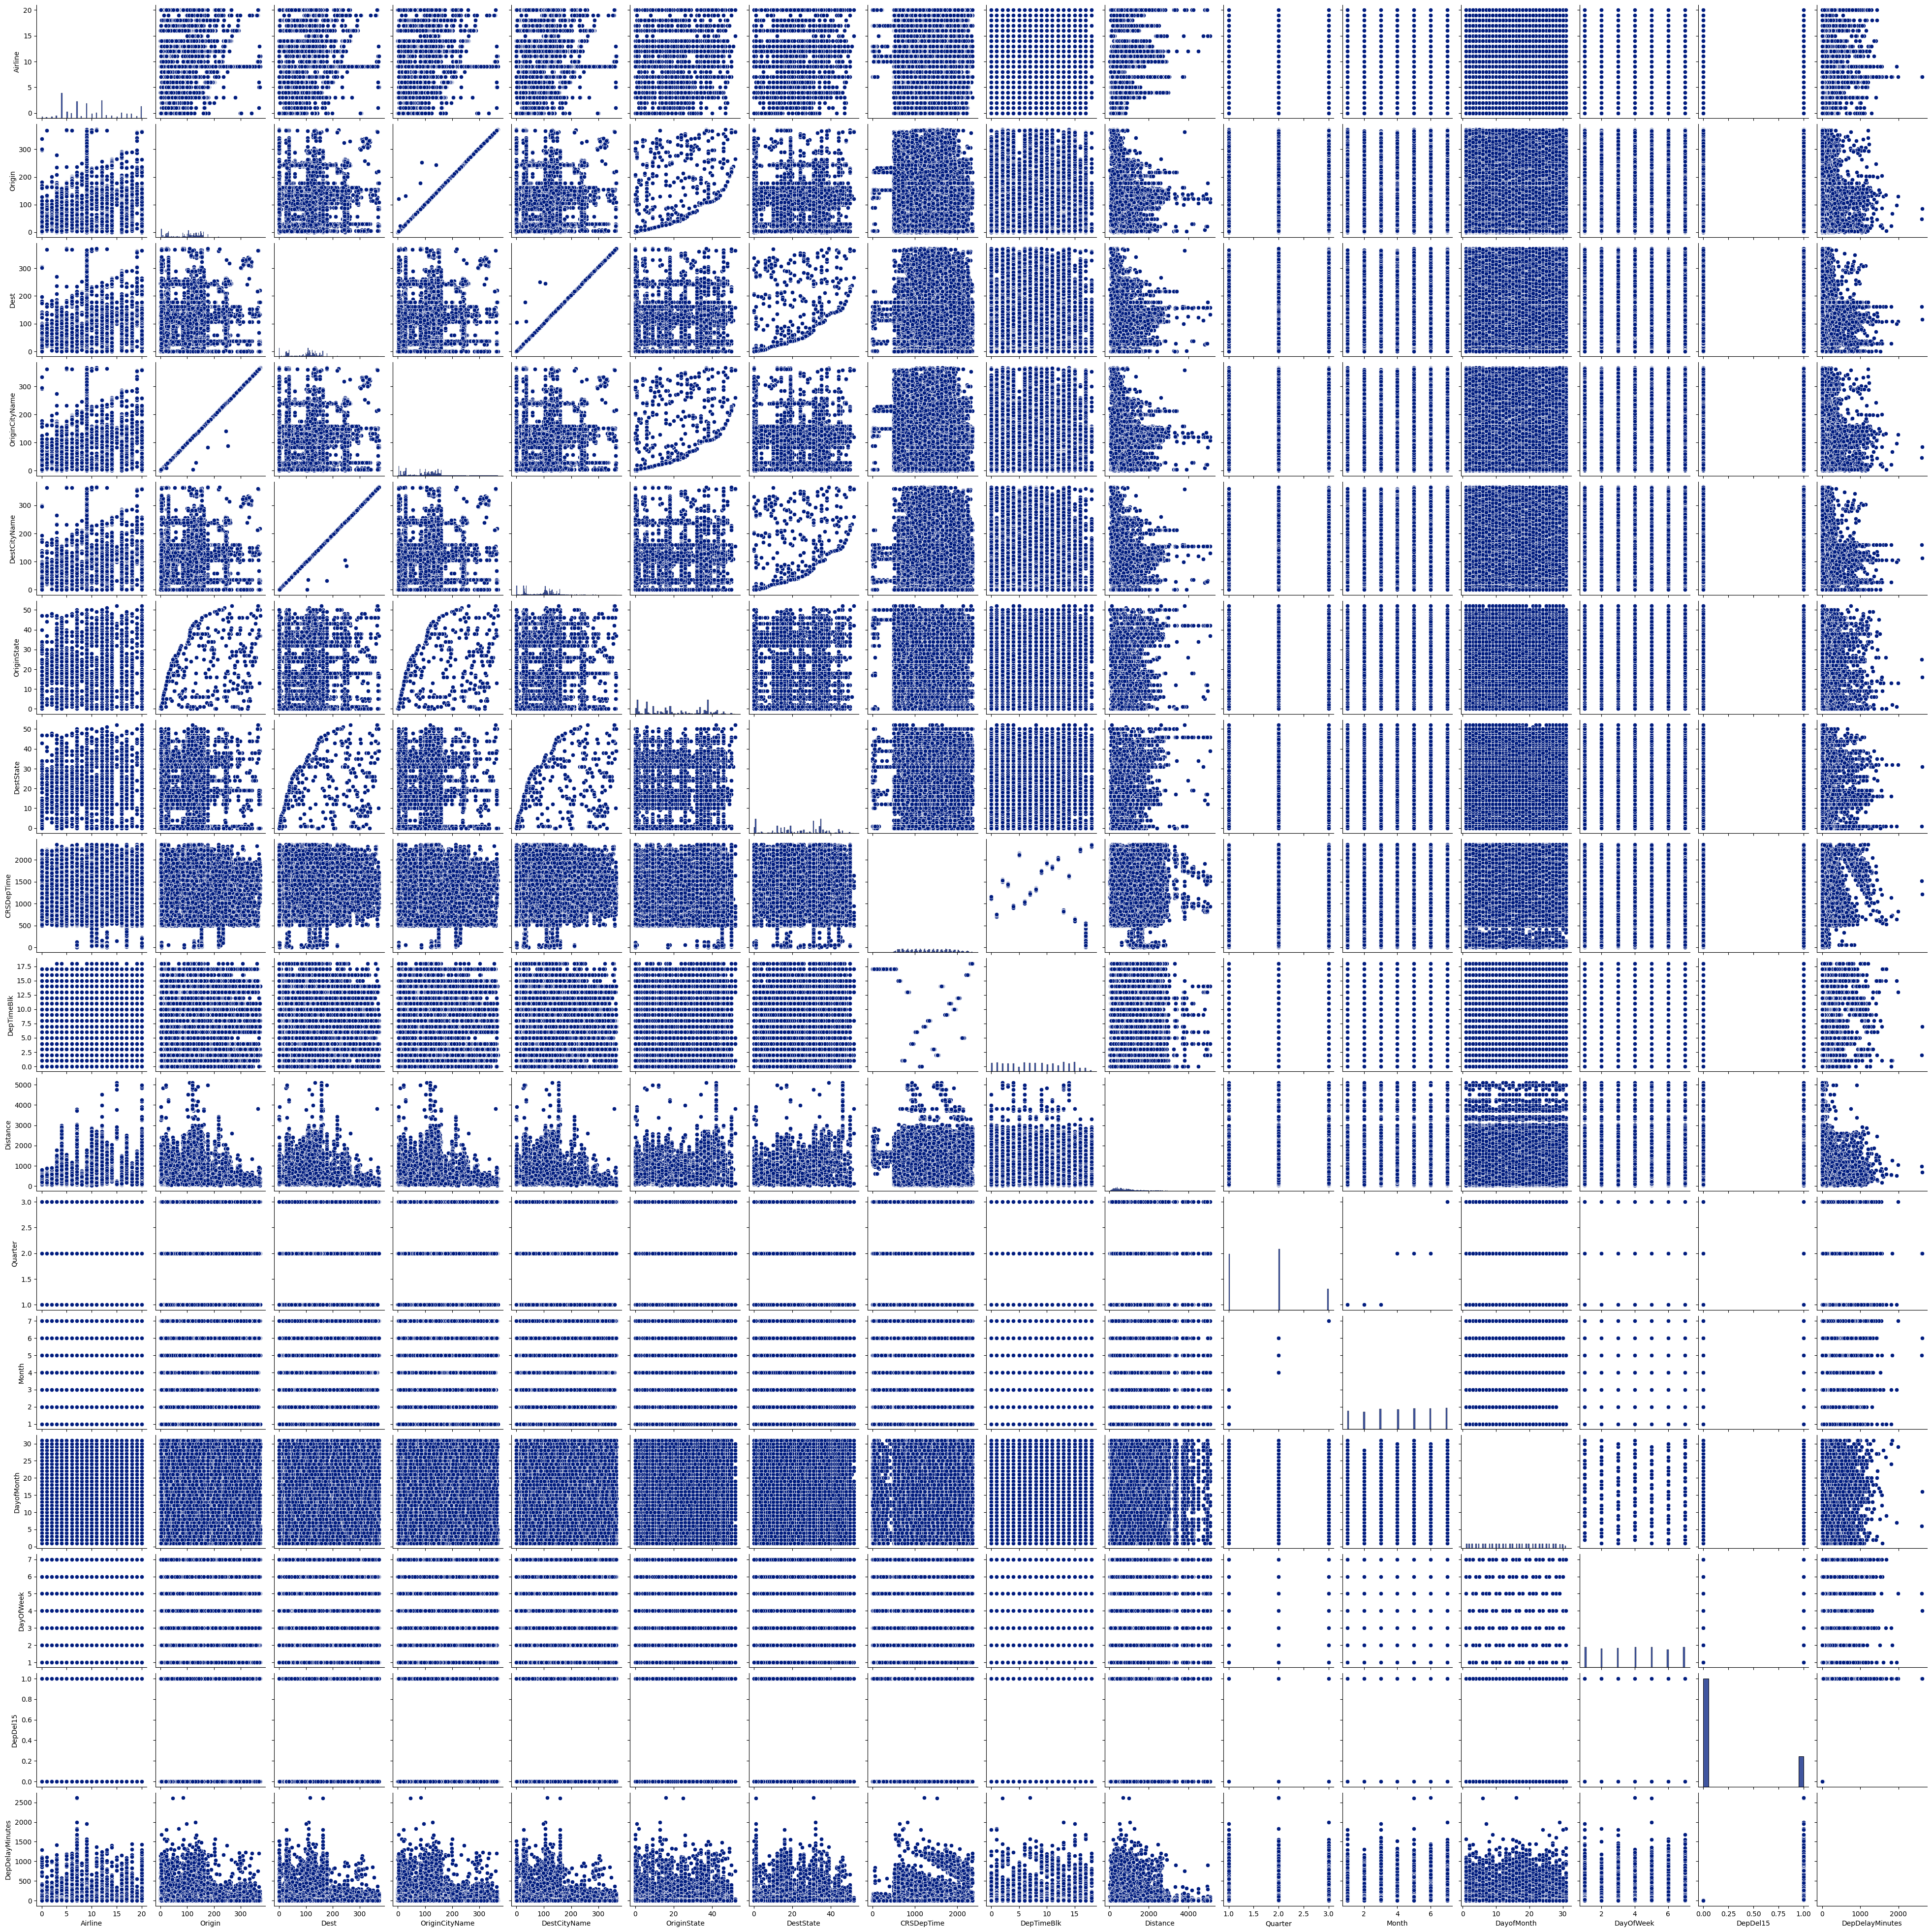

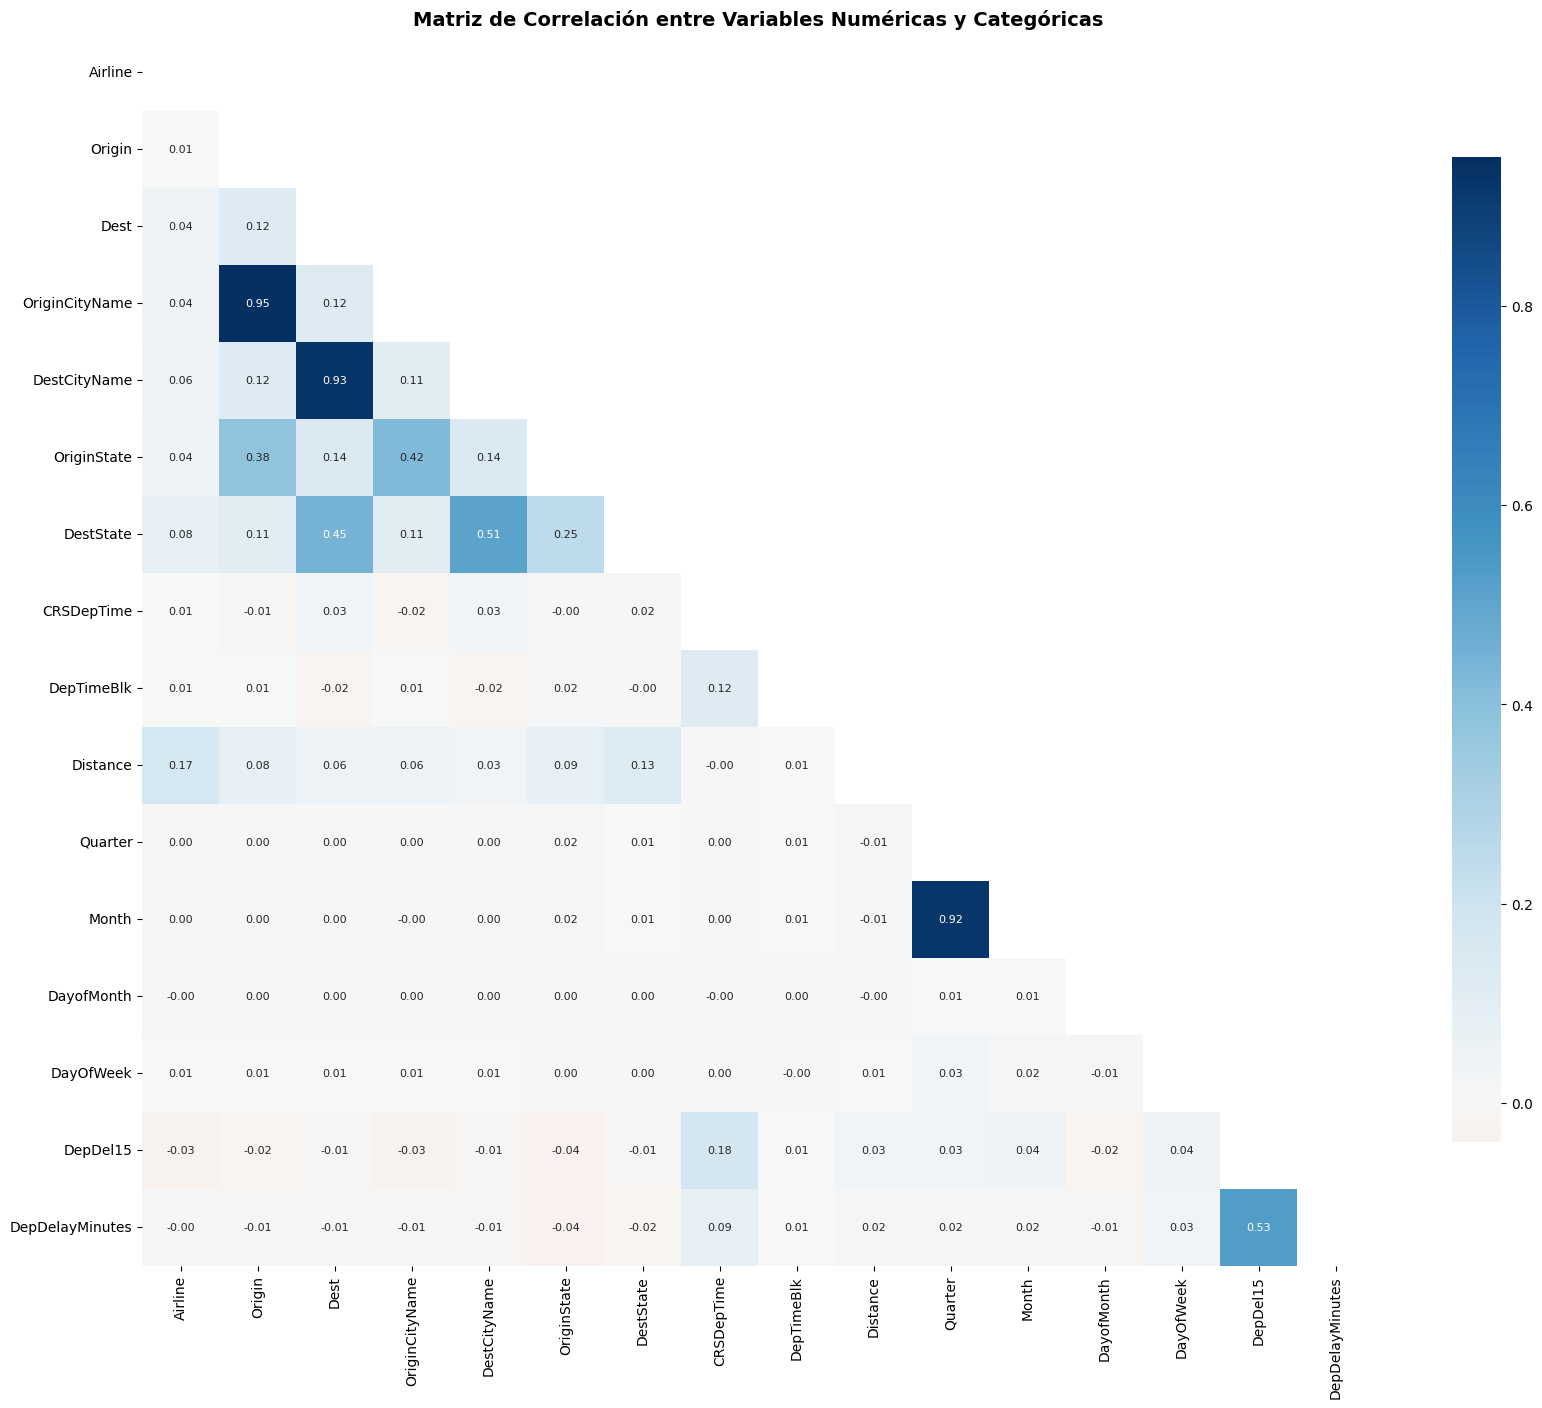

In [31]:
#Pairplot para visualizar relaciones entre variables
plt.figure(figsize=(12, 12))
sns.pairplot(data=df_enc.sample(frac=0.1, random_state=42))  #Muestra del 10% para optimizar rendimiento
plt.show()

#Heatmap para visualizar la matriz de correlación
plt.figure(figsize=(20, 16))
corr_matrix = df_enc.corr()

sns.heatmap(corr_matrix.round(2), 
            annot=True,
            mask=np.triu(corr_matrix),  #Oculta la mitad superior para claridad
            cmap='RdBu',
            center=0,
            square=True,
            fmt='.2f',
            annot_kws={'size': 8},  
            cbar_kws={'shrink': .8}
            )
plt.title("Matriz de Correlación entre Variables Numéricas y Categóricas", fontsize=14, fontweight='bold')
plt.show()